<a href="https://www.kaggle.com/code/zaki171/google-stock-prices-time-series-forecasting?scriptVersionId=113563181" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv
/kaggle/input/google-stock-prices-since-the-pandemic-started/stock_prices.csv
/kaggle/input/google-stock-prices-270921-230922/GOOG.csv


# Gathering the data 

Taking a (brief) look at the NYSE data

In [2]:
prices = pd.read_csv('/kaggle/input/nyse/prices-split-adjusted.csv')
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
prices.tail()

,date,symbol,open,close,low,high,volume
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
851263,2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [4]:
prices.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [5]:
prices.shape

(851264, 7)

In [6]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [7]:
prices['date'] = prices['date'].apply(pd.to_datetime)
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


* Open and Close represent opening and closing prices of the stock per day (when the markets open and then close).
* High and Low represent the highest/lowest price of the stock during that day.
* Volume is the number of stocks traded that day

# Focusing on Google

In [8]:
prices.symbol.value_counts()

KSU     1762
NOC     1762
ORCL    1762
OMC     1762
OKE     1762
        ... 
KHC      378
HPE      304
CSRA     284
WLTW     251
FTV      126
Name: symbol, Length: 501, dtype: int64

501 stocks, notice how top trades share the same number

In [9]:
google = prices.loc[prices.symbol == 'GOOG']
google.head()

,date,symbol,open,close,low,high,volume
439,2010-01-04,GOOG,312.304948,312.205308,310.955001,313.580158,3927000.0
907,2010-01-05,GOOG,312.419511,310.830459,309.610028,312.748278,6031900.0
1375,2010-01-06,GOOG,311.761979,302.994813,302.048370,311.761979,7987100.0
1843,2010-01-07,GOOG,303.562685,295.941242,295.218951,303.861575,12876600.0
2311,2010-01-08,GOOG,294.895159,299.886470,293.455551,300.499172,9483900.0


In [10]:
google.tail()

,date,symbol,open,close,low,high,volume
848963,2016-12-23,GOOG,790.900024,789.909973,787.280029,792.739990,623400.0
849463,2016-12-27,GOOG,790.679993,791.549988,787.656982,797.859985,789100.0
849963,2016-12-28,GOOG,793.700012,785.049988,783.200012,794.229980,1132700.0
850463,2016-12-29,GOOG,783.330017,782.789978,778.919983,785.929993,742200.0
850963,2016-12-30,GOOG,782.750000,771.820007,770.409973,782.780029,1760200.0


<AxesSubplot:xlabel='date', ylabel='open'>

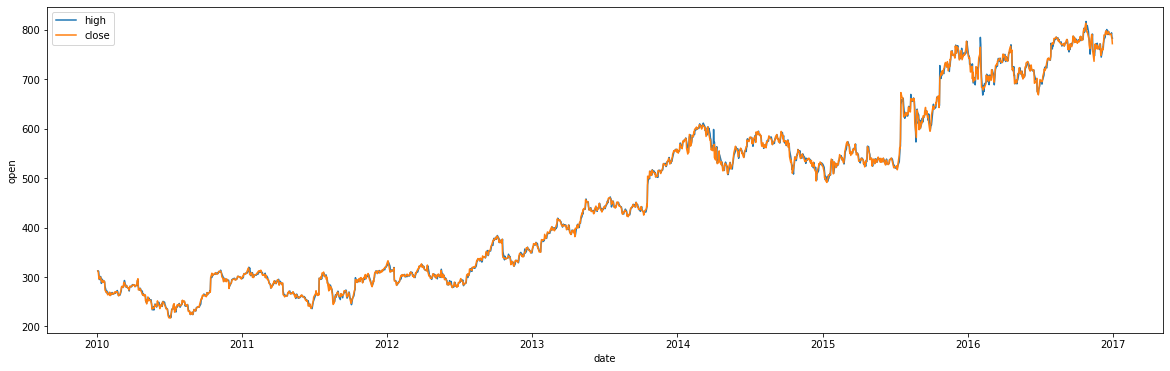

In [11]:
f, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data = google, y = 'open', x = 'date', label = 'high')
sns.lineplot(data = google, y = 'close', x = 'date', label = 'close')

#### Increasing trend

<AxesSubplot:ylabel='Frequency'>

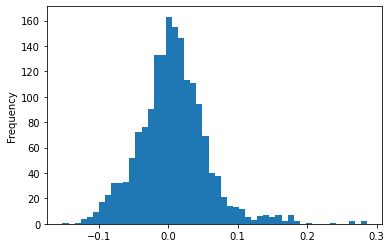

In [12]:
google['close'].pct_change(10).plot.hist(bins=50)

In [13]:
google['10d_lag_close'] = google['close'].shift(-10)
google['lag_10d_pct'] = google['10d_lag_close'].pct_change(10)
google['10d_pct'] = google['close'].pct_change(10)

corr = google[['lag_10d_pct', '10d_pct']].corr()
corr

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,lag_10d_pct,10d_pct
lag_10d_pct,1.000000,-0.038941
10d_pct,-0.038941,1.000000


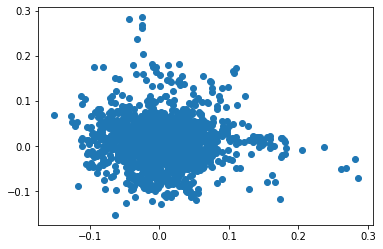

In [14]:

plt.scatter(google['10d_pct'], google['lag_10d_pct'])
plt.show()

<AxesSubplot:xlabel='date', ylabel='high'>

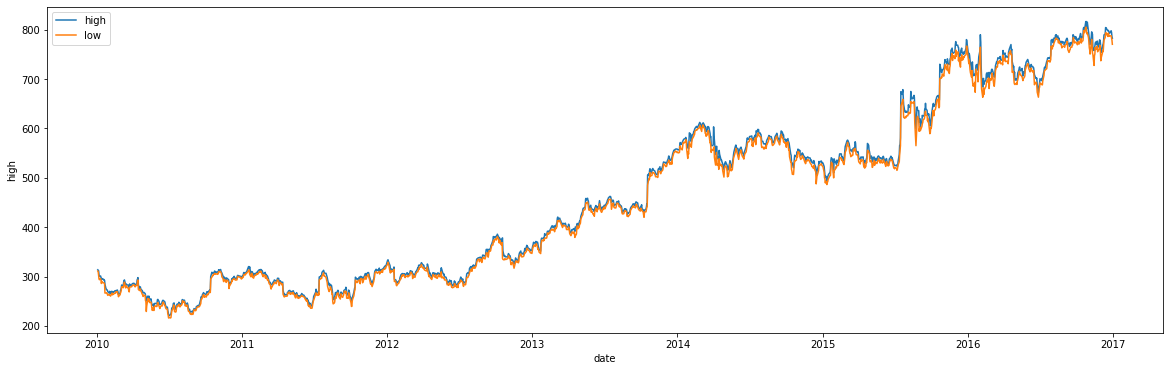

In [15]:
f, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data = google, y = 'high', x = 'date', label = 'high')
sns.lineplot(data = google, y = 'low', x = 'date', label = 'low')

In [16]:
amzn = prices.loc[prices.symbol == 'AMZN']
apple = prices.loc[prices.symbol == 'AAPL']
msft = prices.loc[prices.symbol == 'MSFT']
yhoo = prices.loc[prices.symbol == 'YHOO']

<AxesSubplot:xlabel='date', ylabel='close'>

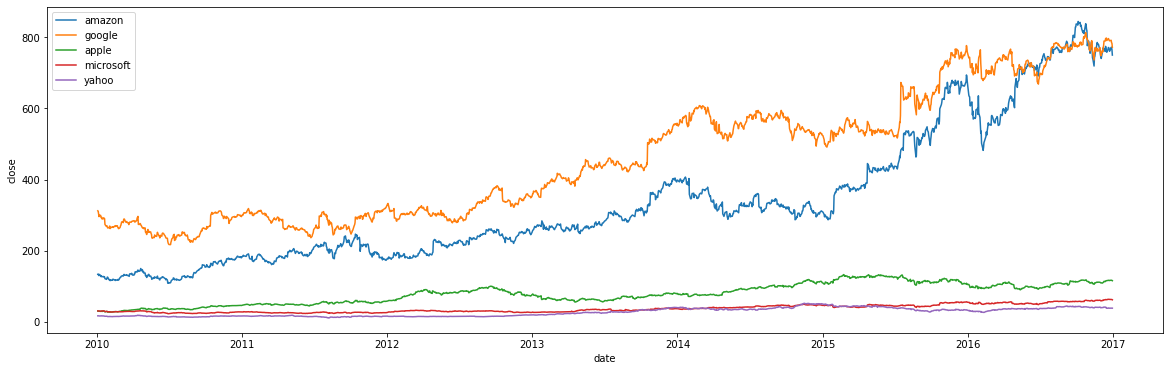

In [17]:
f, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data = amzn, y = 'close', x = 'date', label = 'amazon')
sns.lineplot(data = google, y = 'close', x = 'date', label = 'google')
sns.lineplot(data = apple, y = 'close', x = 'date', label = 'apple')
sns.lineplot(data = msft, y = 'close', x = 'date', label = 'microsoft')
sns.lineplot(data = yhoo, y = 'close', x = 'date', label = 'yahoo')

#### Google is performing well relative to its competitors!

<AxesSubplot:xlabel='date', ylabel='volume'>

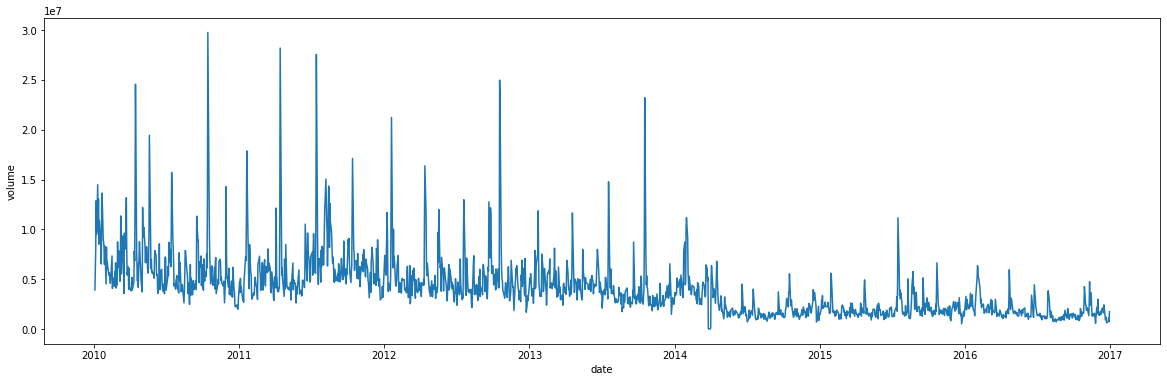

In [18]:
f, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data = google, x = 'date', y = 'volume')

#### Trend slightly decreases

In [19]:
google = google.set_index('date')

<AxesSubplot:xlabel='date'>

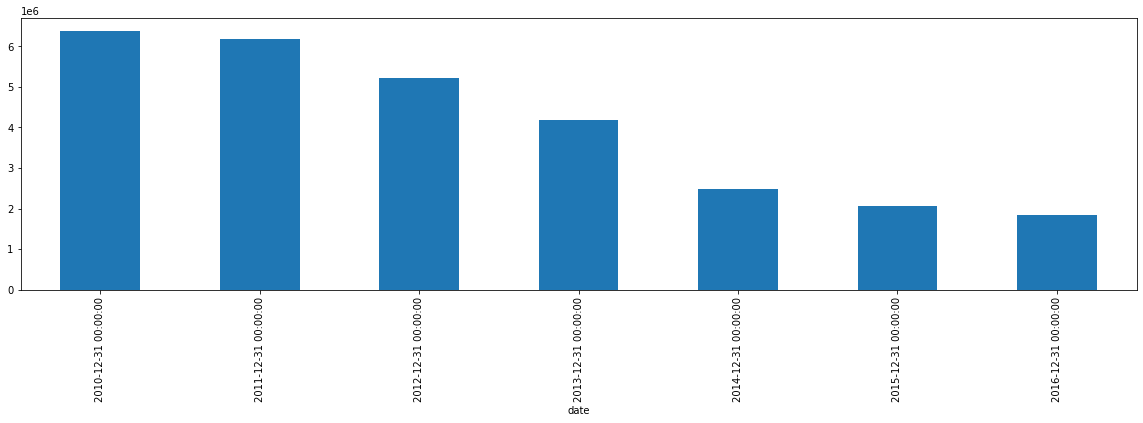

In [20]:
plt.figure(figsize=(20,5))
google['volume'].resample('Y').mean().plot.bar()

#### Stock prices increasing but volume traded decreasing - more people holding on to their (google) stocks.

### This has given us a rough idea of the Google Stocks before COVID-19. Prices were increasing but volume of stocks traded were dropping. This indicates a 'lack of interest' and a potential price reversal. Let's now take a look at a more recent dataset...

# Google stocks since COVID

Taking a look at a different dataset about the stocks of Google more recently.

In [21]:
google_covid = pd.read_csv('/kaggle/input/google-stock-prices-since-the-pandemic-started/stock_prices.csv', parse_dates = ['Date'], index_col = 'Date')
google_covid.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-11,62.485001,63.048000,59.803501,60.770500,60.770500,52170000
2020-03-12,56.299999,59.693501,55.665001,55.745499,55.745499,84534000
2020-03-13,58.950001,60.987999,55.857151,60.986500,60.986500,74002000
2020-03-16,54.799999,57.613350,53.722000,54.216499,54.216499,85048000
2020-03-17,54.655499,56.542999,52.800499,55.990002,55.990002,77230000


In [22]:
google_covid.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-09-06,108.135002,108.879997,106.510002,107.480003,107.480003,20565100
2022-09-07,107.760002,110.989998,107.614998,110.480003,110.480003,22987200
2022-09-08,109.180000,110.580002,108.059998,109.419998,109.419998,21660700
2022-09-09,110.050003,112.000000,110.000000,111.779999,111.779999,21732900
2022-09-12,111.989998,112.639999,110.930000,111.870003,111.870003,19714200


In [23]:
google_covid.shape

(632, 6)

In [24]:
google_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 632 entries, 2020-03-11 to 2022-09-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       632 non-null    float64
 1   High       632 non-null    float64
 2   Low        632 non-null    float64
 3   Close      632 non-null    float64
 4   Adj Close  632 non-null    float64
 5   Volume     632 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 34.6 KB


In [25]:
google_covid.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-11,62.485001,63.048000,59.803501,60.770500,60.770500,52170000
2020-03-12,56.299999,59.693501,55.665001,55.745499,55.745499,84534000
2020-03-13,58.950001,60.987999,55.857151,60.986500,60.986500,74002000
2020-03-16,54.799999,57.613350,53.722000,54.216499,54.216499,85048000
2020-03-17,54.655499,56.542999,52.800499,55.990002,55.990002,77230000


<AxesSubplot:xlabel='Date', ylabel='Volume'>

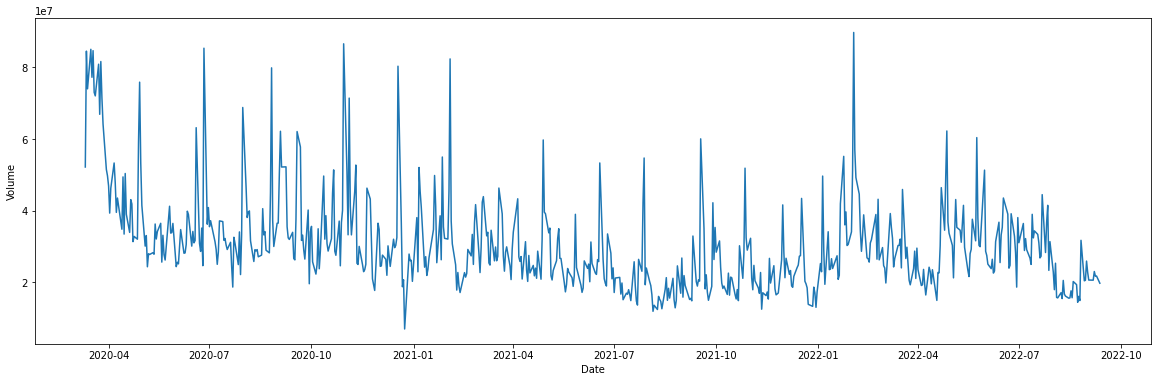

In [26]:
f, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data = google_covid, x = 'Date', y = 'Volume')

<AxesSubplot:xlabel='Date'>

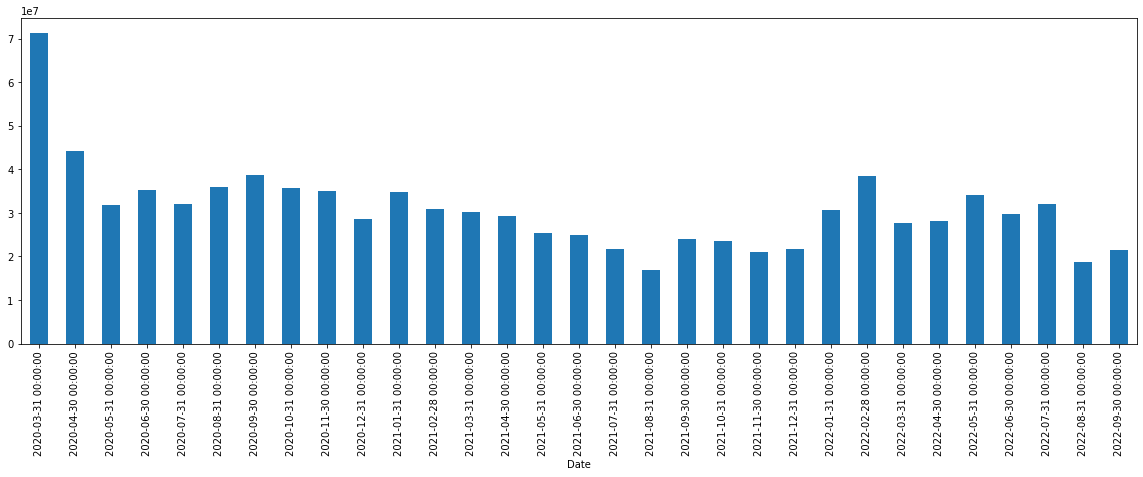

In [27]:
f, ax = plt.subplots(figsize=(20,6))
google_covid['Volume'].resample('M').mean().plot.bar()

#### Huge drop between March and April 2020 - stock market crash during COVID-19.

<AxesSubplot:xlabel='Date', ylabel='Open'>

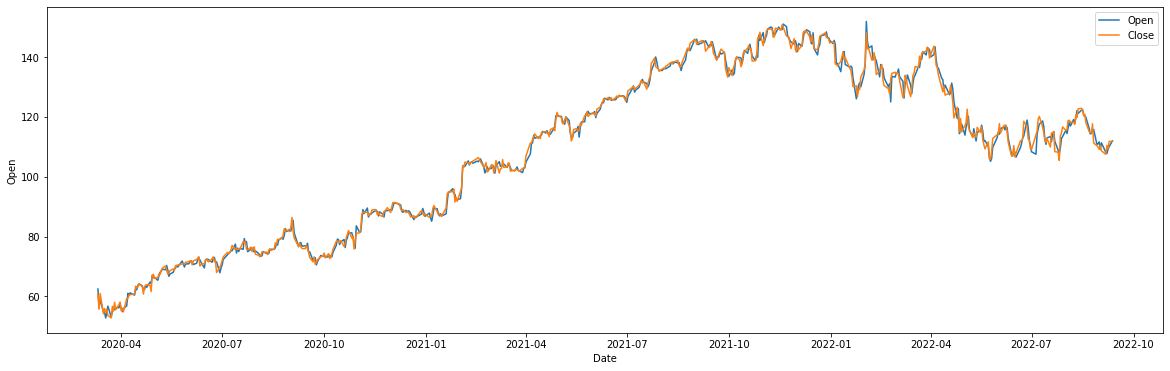

In [28]:
f, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data = google_covid, y = 'Open', x = 'Date', label = 'Open')
sns.lineplot(data = google_covid, y = 'Adj Close', x = 'Date', label = 'Close')

#### Since COVID there has been a steady increase in price up until April 2022, where a drop occurred. 

<AxesSubplot:xlabel='Date', ylabel='High'>

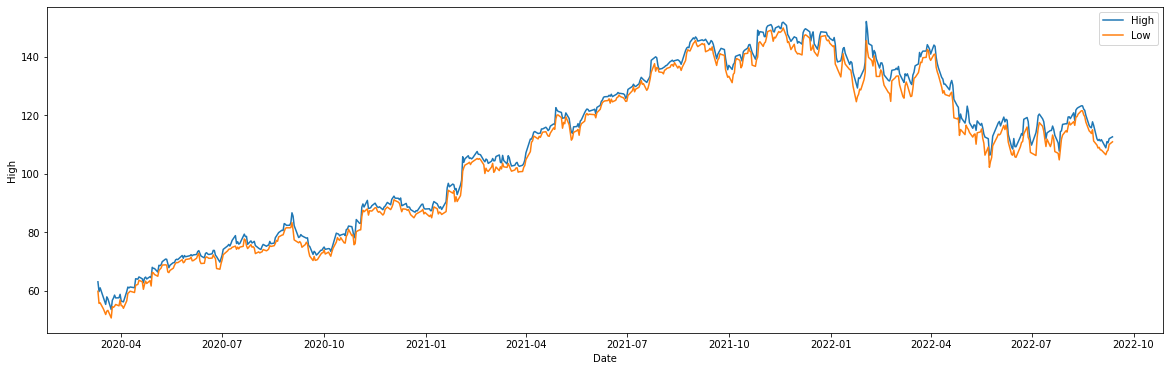

In [29]:
f, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data = google_covid, y = 'High', x = 'Date', label = 'High')
sns.lineplot(data = google_covid, y = 'Low', x = 'Date', label = 'Low')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 5)'>

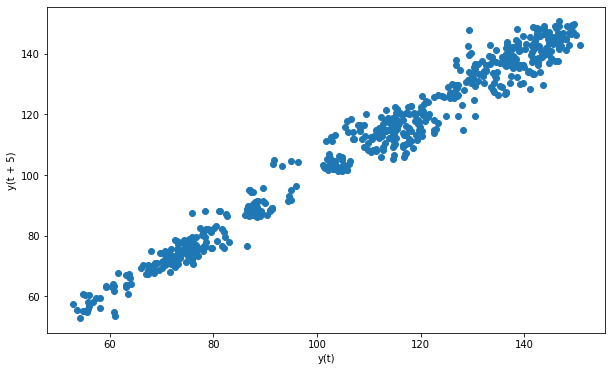

In [30]:
from pandas.plotting import lag_plot
f, ax = plt.subplots(figsize=(10,6))
lag_plot(google_covid['Adj Close'], lag = 5)

#### Strong positive autocorrelation

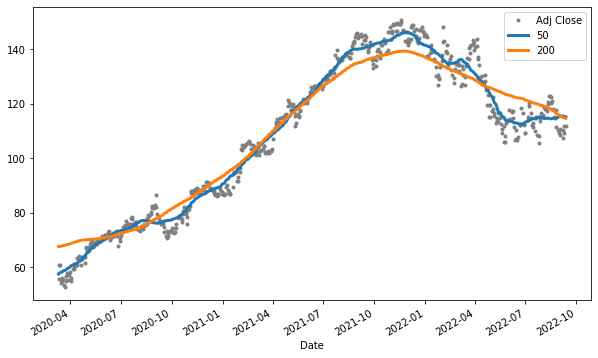

In [31]:
f, ax = plt.subplots(figsize=(10,6))
ax = google_covid['Adj Close'].plot(style=".", color="0.5")

moving_average = google_covid['Adj Close'].rolling(window = 50, center = True, min_periods = 25).mean()
moving_average_200 = google_covid['Adj Close'].rolling(window = 200, center = True, min_periods = 100).mean()
moving_average.plot(linewidth = 3, label = '50')
moving_average_200.plot(label = '200', linewidth = 3)
leg = ax.legend();

#### When the 50-day moving average rises above the 200-day moving average, this may signal a trader to long stocks (and short stocks when it falls below).

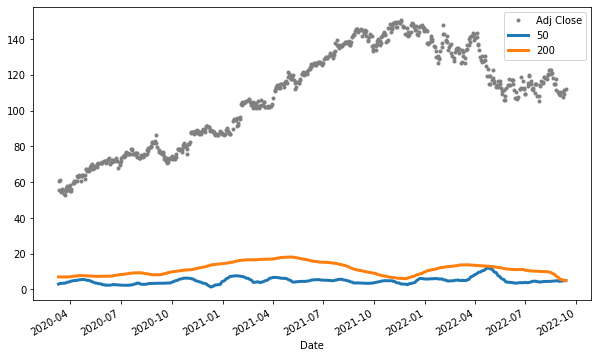

In [32]:
f, ax = plt.subplots(figsize=(10,6))
ax = google_covid['Adj Close'].plot(style=".", color="0.5")

moving_average = google_covid['Adj Close'].rolling(window = 50, center = True, min_periods = 25).std()
moving_average_200 = google_covid['Adj Close'].rolling(window = 200, center = True, min_periods = 100).std()
moving_average.plot(linewidth = 3, label = '50')
moving_average_200.plot(label = '200', linewidth = 3)
leg = ax.legend();

#### Rolling standard deviation seems fairly constant

In [33]:
google_covid['Daily Return'] = google_covid['Adj Close'].pct_change()
google_covid.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-03-11,62.485001,63.048000,59.803501,60.770500,60.770500,52170000,NaN
2020-03-12,56.299999,59.693501,55.665001,55.745499,55.745499,84534000,-0.082688
2020-03-13,58.950001,60.987999,55.857151,60.986500,60.986500,74002000,0.094017
2020-03-16,54.799999,57.613350,53.722000,54.216499,54.216499,85048000,-0.111008
2020-03-17,54.655499,56.542999,52.800499,55.990002,55.990002,77230000,0.032711


<AxesSubplot:xlabel='Date', ylabel='Daily Return'>

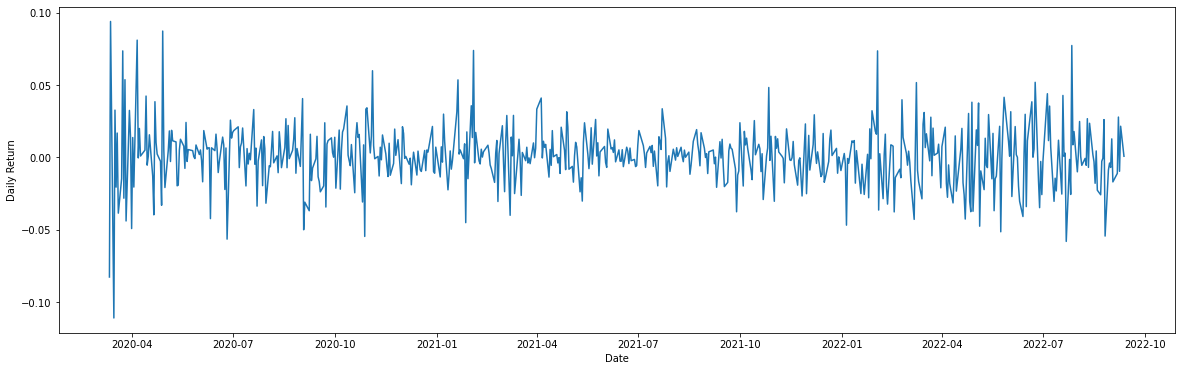

In [34]:
f, ax = plt.subplots(figsize=(20,6))
sns.lineplot(data = google_covid, x = 'Date', y = 'Daily Return')

<AxesSubplot:xlabel='Daily Return', ylabel='Density'>

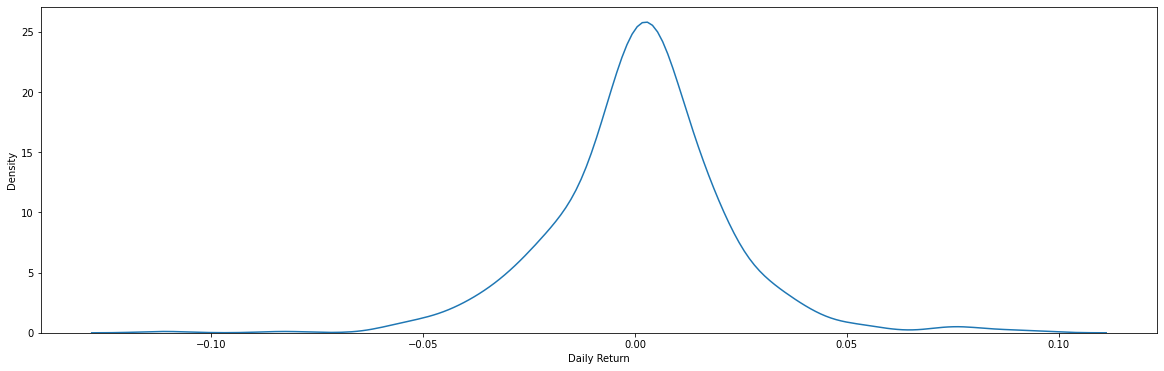

In [35]:
f, ax = plt.subplots(figsize=(20,6))
sns.kdeplot(data = google_covid,x = 'Daily Return')

# Modelling

### Linear regression is good for extrapolating trends, wheras XGBoost is more suited for learning interacrions. XGBoost cannot extrapolate trends. 

We create a hybrid model to leverage both uses...

series = trend + seasons + cycles + error.
We use linear regression to fit the original series and Boosting to fit the residual errors, and then add to get the final prediction.

### Linear Regression

In [36]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
y = google_covid['Adj Close']
dp = DeterministicProcess(index = google_covid.index, constant = True, order = 3, drop = True) #Order 3 polynomial
X = dp.in_sample()
X.head()

,const,trend,trend_squared,trend_cubed
Date,,,,
2020-03-11,1.0,1.0,1.0,1.0
2020-03-12,1.0,2.0,4.0,8.0
2020-03-13,1.0,3.0,9.0,27.0
2020-03-16,1.0,4.0,16.0,64.0
2020-03-17,1.0,5.0,25.0,125.0


In [37]:
X.shape

(632, 4)

In [38]:
X_train, X_test = X[0:550], X[550:] #train test split
y_train, y_test = y[0:550], y[550:]

In [39]:
model = LinearRegression(fit_intercept = False)
model.fit(X_train,y_train)
y_fit = pd.Series(model.predict(X_train), index = y_train.index)
y_pred = pd.Series(model.predict(X_test), index = y_test.index)

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


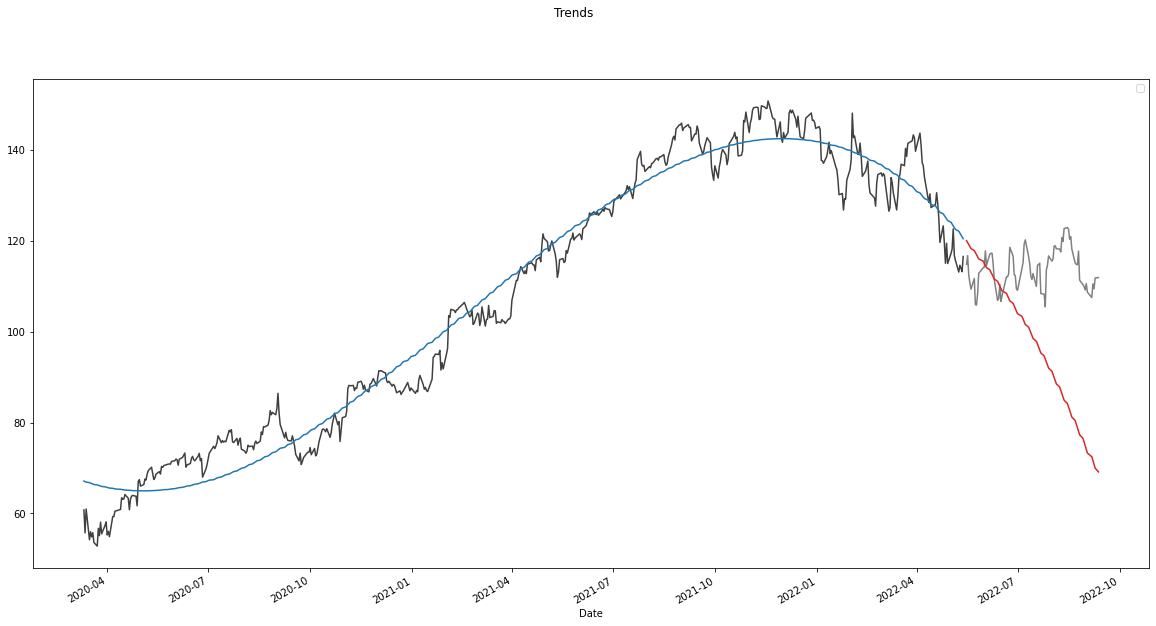

In [40]:
plt.figure(figsize=(20,10))
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.5', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

Doesn't look good, but we haven't trained our residuals yet

In [41]:
X['Month'] = X.index.month

In [42]:
from xgboost import XGBRegressor

y_resid = y_train - y_fit
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_test #prediction

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


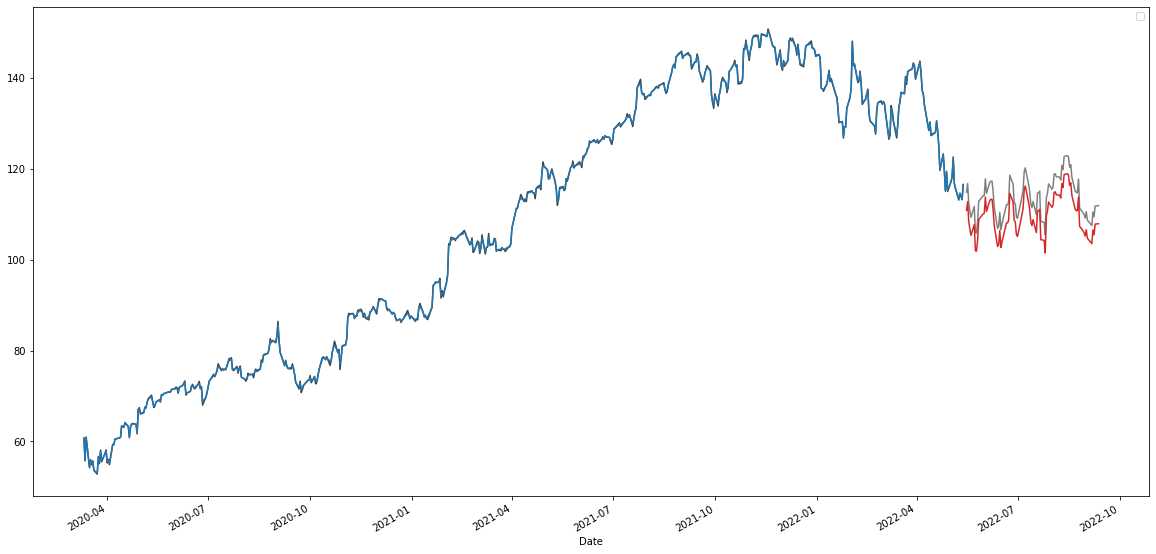

In [43]:
plt.figure(figsize=(20,10))
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.5', subplots=True, sharex=True, ax=axs)
axs = y_fit_boosted.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred_boosted.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])

#### Good fit - important to realise however that XGBoost performance is highly dependent on regression prediction

In [44]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_pred_boosted)

0.03506098101677391

# Using ARIMA

Trying out ARIMA models for the first time for an alternative forecasting approach. We could use auto-ARIMA but I decided to try and calculate the ideal parameters manually.

In [45]:
copy = google_covid.copy()

In [46]:
copy.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-03-11,62.485001,63.048000,59.803501,60.770500,60.770500,52170000,NaN
2020-03-12,56.299999,59.693501,55.665001,55.745499,55.745499,84534000,-0.082688
2020-03-13,58.950001,60.987999,55.857151,60.986500,60.986500,74002000,0.094017
2020-03-16,54.799999,57.613350,53.722000,54.216499,54.216499,85048000,-0.111008
2020-03-17,54.655499,56.542999,52.800499,55.990002,55.990002,77230000,0.032711


In [47]:
copy.index

DatetimeIndex(['2020-03-11', '2020-03-12', '2020-03-13', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-23', '2020-03-24',
               ...
               '2022-08-29', '2022-08-30', '2022-08-31', '2022-09-01',
               '2022-09-02', '2022-09-06', '2022-09-07', '2022-09-08',
               '2022-09-09', '2022-09-12'],
              dtype='datetime64[ns]', name='Date', length=632, freq=None)

In [48]:
copy = copy.asfreq('b')

#### ^We require this for out of sample forecasting.

In [49]:
copy.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2020-03-11,62.485001,63.048000,59.803501,60.770500,60.770500,52170000.0,NaN
2020-03-12,56.299999,59.693501,55.665001,55.745499,55.745499,84534000.0,-0.082688
2020-03-13,58.950001,60.987999,55.857151,60.986500,60.986500,74002000.0,0.094017
2020-03-16,54.799999,57.613350,53.722000,54.216499,54.216499,85048000.0,-0.111008
2020-03-17,54.655499,56.542999,52.800499,55.990002,55.990002,77230000.0,0.032711


In [50]:
copy['Adj Close'].fillna(method='ffill', inplace=True)

#### Fill the days where we have no data with the previous day's.

In [51]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(copy['Adj Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.983564
p-value: 0.293826


#### p-value greater than 0.05, so our data is not stationary. 

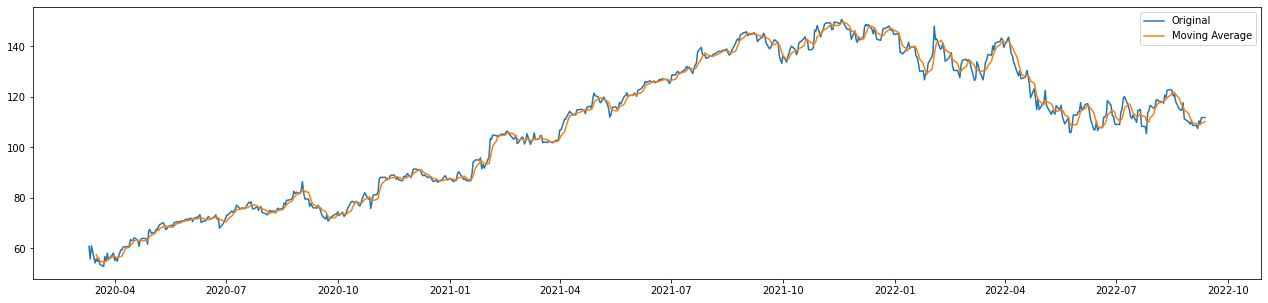

In [52]:
X = copy['Adj Close']
moving_average = X.rolling(5).mean()
plt.figure(figsize=(22,5))
plt.plot(X, label = 'Original')
plt.plot(moving_average, label = 'Moving Average')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Date'>

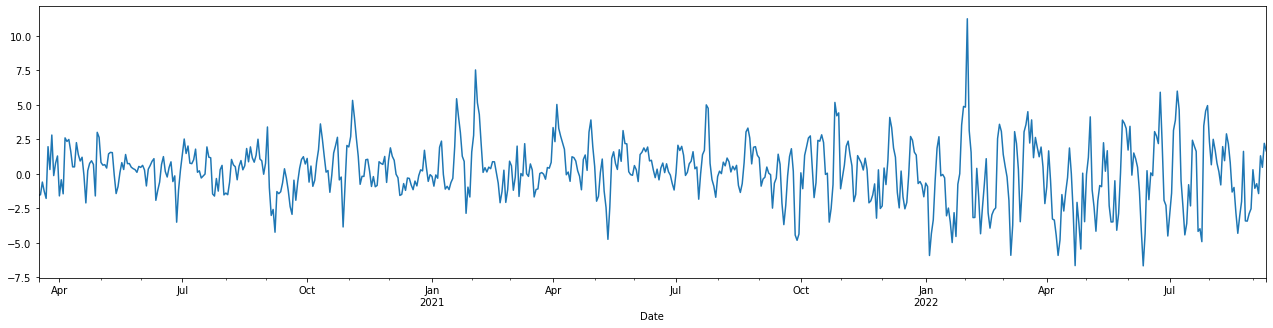

In [53]:
plt.figure(figsize=(22,5))
diff = X - moving_average
diff.dropna(inplace = True)
diff.plot()

#### Detrended

In [54]:
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %s' % result[1])

ADF Statistic: -13.755043
p-value: 1.0334021975152513e-25


#### Not stationary anymore!

Text(0.5, 1.0, 'PACF')

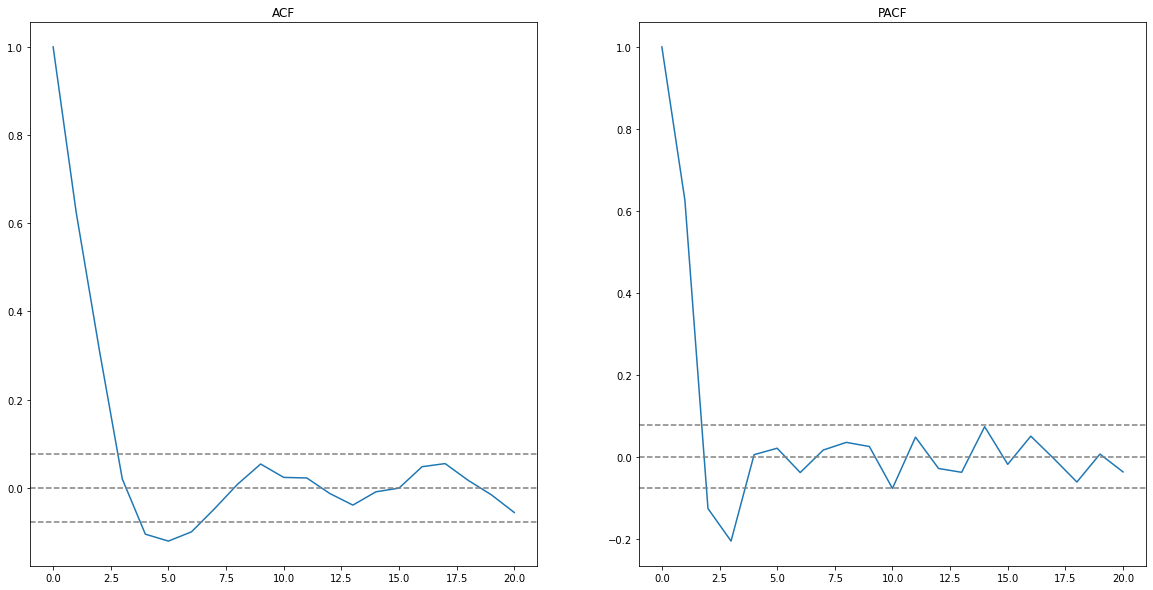

In [55]:
from statsmodels.tsa.stattools import adfuller,acf,pacf

lag_acf = acf(diff, nlags = 20)
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('ACF')
lag_pacf = pacf(diff, nlags=20)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('PACF')
  

p = 2 from PACF
q = 3 from ACF

In [56]:
from statsmodels.tsa.arima.model import ARIMA


model = ARIMA(diff, order=(2,1,3))
model_fit = model.fit()
print(model_fit.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  650
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1235.488
Date:                Sun, 11 Dec 2022   AIC                           2482.977
Time:                        22:54:25   BIC                           2509.829
Sample:                    03-17-2020   HQIC                          2493.393
                         - 09-12-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6717      0.157      4.283      0.000       0.364       0.979
ar.L2         -0.2791      0.100     -2.792      0.005      -0.475      -0.083
ma.L1         -0.9820      0.151     -6.485      0.0

<AxesSubplot:xlabel='Date'>

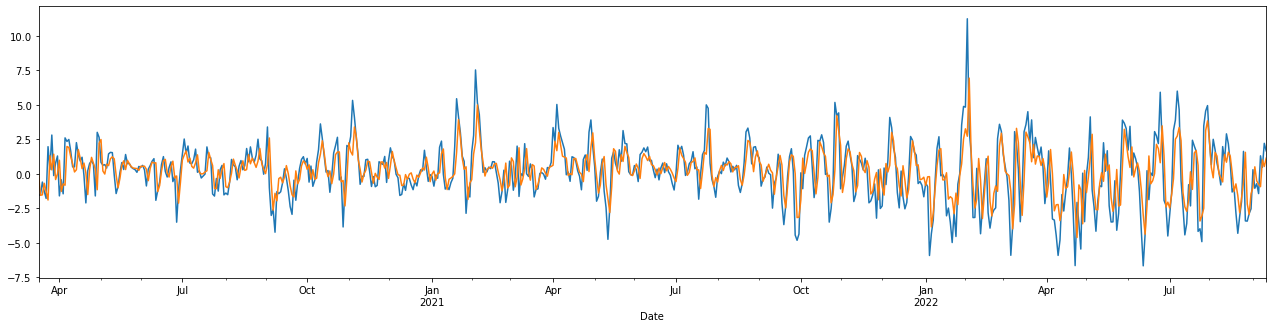

In [57]:
plt.figure(figsize=(22,5))
diff.plot()
model_fit.fittedvalues.plot()

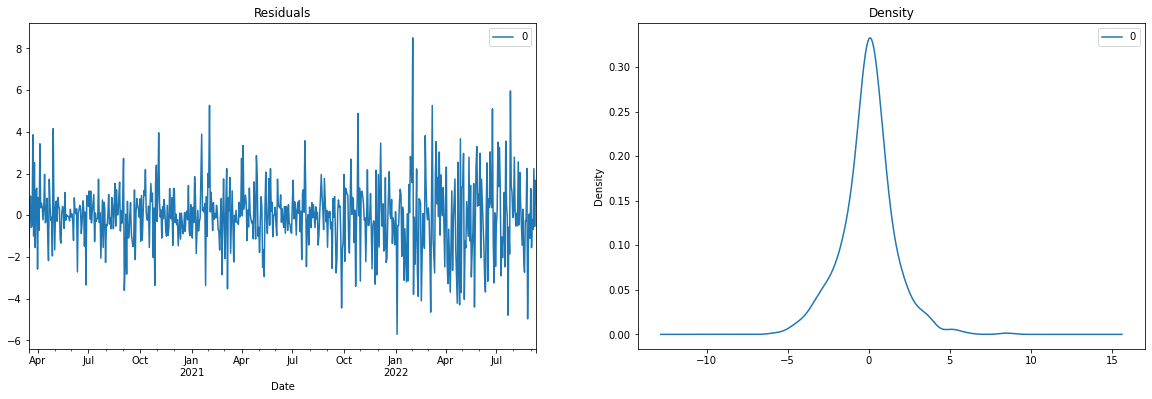

In [58]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(20,6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [59]:
preds_diff = pd.Series(model_fit.fittedvalues, copy = True)
preds_diff

Date
2020-03-17    0.000000
2020-03-18   -1.551798
2020-03-19   -1.518932
2020-03-20   -0.683272
2020-03-23   -1.273470
                ...   
2022-09-06   -0.752384
2022-09-07   -0.928474
2022-09-08    1.012254
2022-09-09    0.533162
2022-09-12    1.135438
Freq: B, Length: 650, dtype: float64

In [60]:
preds = pd.Series(X.iloc[0], index = X.index)

In [61]:
preds = preds.add(preds_diff.cumsum(), fill_value = 0)

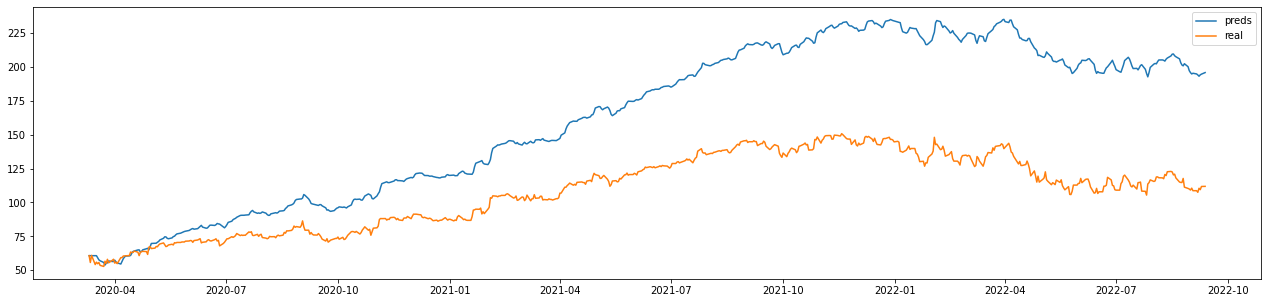

In [62]:
plt.figure(figsize=(22,5))
plt.plot(preds, label = 'preds')
plt.plot(X, label = 'real')
plt.legend()
plt.show()

In [63]:
X.tail()

Date
2022-09-06    107.480003
2022-09-07    110.480003
2022-09-08    109.419998
2022-09-09    111.779999
2022-09-12    111.870003
Freq: B, Name: Adj Close, dtype: float64

In [64]:
forecast_diff = model_fit.forecast(steps=120)

In [65]:
forecast = pd.Series(X.iloc[-1], index = forecast_diff.index)
forecast = forecast.add(forecast_diff.cumsum(), fill_value = 0)

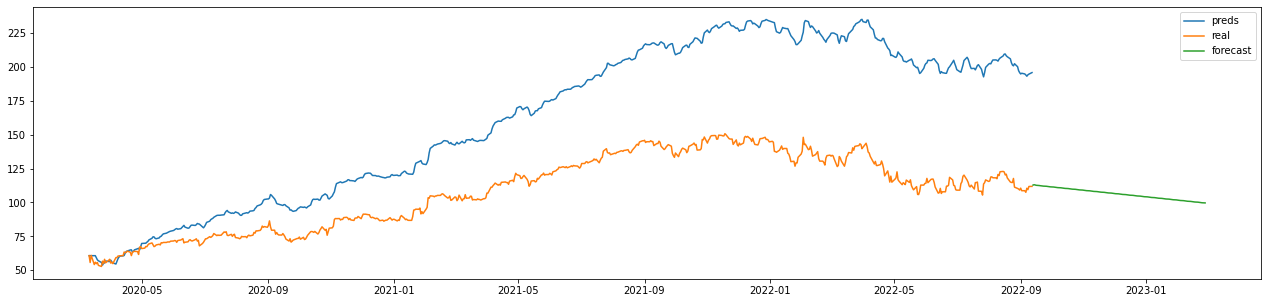

In [66]:
plt.figure(figsize=(22,5))
plt.plot(preds, label = 'preds')
plt.plot(X, label = 'real')
plt.plot(forecast, label = 'forecast')
plt.legend()
plt.show()

#### Our forecast indicates a slight decrease in the trend